In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('https://raw.githubusercontent.com/MATF-istrazivanje-podataka-1/2023_Data_Mining_Chess_Dataset/main/Preprocessing/preprocessed_set(1).csv')

In [104]:
data.head()
data.drop(columns=['Unnamed: 0'],inplace=True)
indexes=data[data['winner']==0]

In [107]:
data.winner.unique()
potezi=data.moves
data.drop(columns=['moves'],inplace=True)

# Klasifikacija

Zelimo da postupkom kalsifikacije na osnovu podataka iz tabele predvidimo da li je pobedio crni ili beli. U skupu nema neresenih

<BarContainer object of 2 artists>

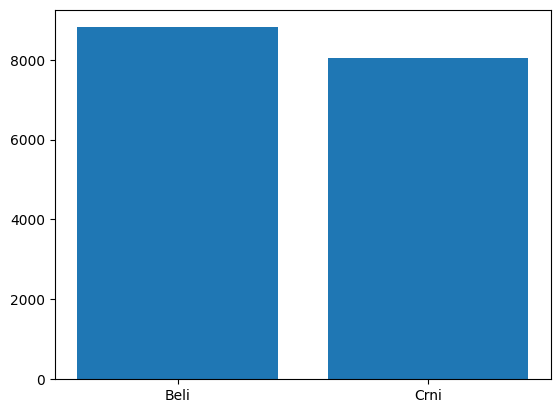

In [108]:
d=data.winner.value_counts()
plt.bar(["Beli","Crni"],[d.iloc[0],d.iloc[1]])

In [109]:
len(data)

16865

Klase su balansirane u odnosu 52-48% u korist belog i zato nece biti potrebe za uzorkovanjem

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

##Konverzija otvaranja (ovo prebaciti u preprocesiranje)

In [111]:
otvaranja=data['opening_eco']
def convert_op_eco(s):
  s=s.strip()
  return (ord(s[0])-ord('A')+1)*100+int(s[1]+s[2])
otvaranja
print(convert_op_eco('Z20'))
otv_int=list(map(convert_op_eco,otvaranja))
data['opening_eco']=otv_int
data.head()

2620


,rated,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply,increment_code
0,1,16,1,0,1322,1261,200,4,2
1,1,61,2,1,1439,1454,402,3,2
2,1,95,2,1,1523,1469,341,5,3
3,1,33,1,1,1520,1423,400,10,2
4,0,9,1,0,1413,2108,200,5,3


##Podela na ulazne i ciljne atribute:

In [112]:
Y = data['winner']
X = data.drop(columns=['winner'])
feature_names = X.columns
X.shape
Y.value_counts()

1    8812
0    8053
Name: winner, dtype: int64

##Podela na test i trening skupove:

In [113]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [114]:
def report(y_real, y_pred):
    print('Confusion matrix:')
    print(confusion_matrix(y_real, y_pred))
    print('Accuracy score:')
    print(accuracy_score(y_real, y_pred))
    print('Precision score: ')
    print(precision_score(y_real, y_pred))
    print('Recall score: ')
    print(recall_score(y_real, y_pred))
def new_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    print('Train data:\n')
    y_train_pred = model.predict(X_train)
    report(y_train, y_train_pred)
    
    print('\n--------------------------------------\n')

    print('Test data:\n')
    y_pred = model.predict(X_test)
    report(y_test, y_pred)

    return model

In [115]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(random_state=55)
dtc = new_model(dtc, X_train, X_test, Y_train, Y_test)
#error zbog otvaranja

Train data:

Confusion matrix:
[[5999    0]
 [   0 6649]]
Accuracy score:
1.0
Precision score: 
1.0
Recall score: 
1.0

--------------------------------------

Test data:

Confusion matrix:
[[1150  904]
 [ 841 1322]]
Accuracy score:
0.5861987194688167
Precision score: 
0.5938903863432166
Recall score: 
0.6111881645862228


Pokusano je i sa modelima gde je velicina test skupa 20% i 30% velicine originalnog skupa. Ova podela nam daje najbolje rezultate

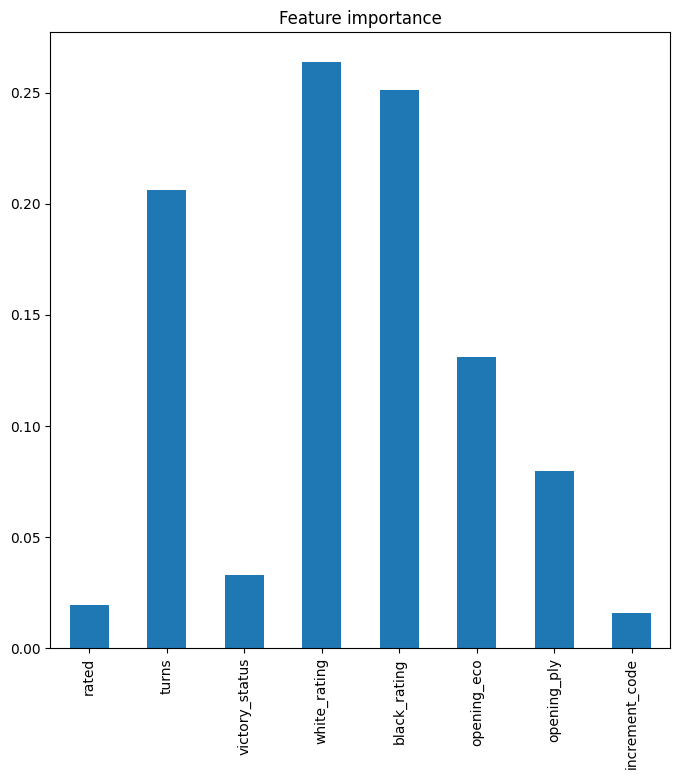

In [116]:
plt.figure(figsize=(8, 8))
pd.Series(dtc.feature_importances_, index=X_train.columns).plot.bar()
plt.title("Feature importance")
plt.show()

Buduci da smo dobili veoma neprecizan model pokusacemo da uvedemo neke statistike da bismo mogli lakse da predvidimo pobednika. Smatra se da je u sahu losa praksa da se igra kraljicom u prvih par poteza pa cemo da vidimo da li njeno prevremeno pomeranje moze da utice na rezultat partije.

In [120]:
def igrao_kraljicom(potezi_split):
  potezi_belog = potezi_split[:16:2]
  potezi_crnog = potezi_split[1:16:2]
  igrali=[0,0]
  for i in potezi_belog:
    if i[0]=='Q':
      igrali[0]=1
  for i in potezi_crnog:
    if i[0]=='Q':
      igrali[1]=1
  return igrali

In [121]:
beli_igrao=[]
crni_igrao=[]
for i in potezi:
  sp_potezi=i.split()
  a=igrao_kraljicom(sp_potezi)
  beli_igrao.append(a[0])
  crni_igrao.append(a[1])
data['white moved the queen']=beli_igrao
data['black moved the queen']=crni_igrao

Podela na trening i test

In [122]:
Y = data['winner']
X = data.drop(columns=['winner'])
feature_names = X.columns
X.columns

Index(['rated', 'turns', 'victory_status', 'white_rating', 'black_rating',
       'opening_eco', 'opening_ply', 'increment_code', 'white moved the queen',
       'black moved the queen'],
      dtype='object')

In [123]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [143]:
dtc_kraljica = tree.DecisionTreeClassifier(random_state=55)
dtc_kraljica = new_model(dtc_kraljica, X_train, X_test, Y_train, Y_test)

Train data:

Confusion matrix:
[[6076    0]
 [   0 6572]]
Accuracy score:
1.0
Precision score: 
1.0
Recall score: 
1.0

--------------------------------------

Test data:

Confusion matrix:
[[1154  823]
 [ 885 1355]]
Accuracy score:
0.5949727294285037
Precision score: 
0.6221303948576676
Recall score: 
0.6049107142857143


Dobili smo malo bolje rezultate ali je ovaj model i dalje dosta neprecizan. Pokusacemo da poboljsamo model podesavanjem hiperparametara pomocu unakrsne validacije

#GridSearchCV

In [126]:
from sklearn.model_selection import GridSearchCV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [2,4,6, 8]
         }
estimator = GridSearchCV(DecisionTreeClassifier(random_state=55), param_grid=params, cv=3)
estimator.fit(X_train, Y_train)
estimator.best_params_

{'criterion': 'entropy', 'max_depth': 8}

In [127]:
estimator.best_score_

0.6346457938013915

In [128]:
estimator=new_model(estimator,X_train, X_test, Y_train, Y_test)

Train data:

Confusion matrix:
[[4131 1945]
 [2230 4342]]
Accuracy score:
0.6699082858950032
Precision score: 
0.690631461746461
Recall score: 
0.6606816798539258

--------------------------------------

Test data:

Confusion matrix:
[[1259  718]
 [ 832 1408]]
Accuracy score:
0.6324401233104102
Precision score: 
0.6622765757290687
Recall score: 
0.6285714285714286


#Random forest

In [129]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=2)
random_forest.fit(X_train, Y_train)
random_forest = new_model(random_forest, X_train, X_test, Y_train, Y_test)


Train data:

Confusion matrix:
[[5889  187]
 [1772 4800]]
Accuracy score:
0.8451138519924098
Precision score: 
0.962502506516944
Recall score: 
0.7303712720632989

--------------------------------------

Test data:

Confusion matrix:
[[1532  445]
 [1380  860]]
Accuracy score:
0.5672278871235475
Precision score: 
0.6590038314176245
Recall score: 
0.38392857142857145


Slucajna suma sa 50 stabala

In [130]:
random_forest_50_trees = RandomForestClassifier(n_estimators=50, random_state=42)
random_forest_50_trees.fit(X_train, Y_train)
random_forest_50_trees = new_model(random_forest_50_trees, X_train, X_test, Y_train, Y_test)


Train data:

Confusion matrix:
[[6076    0]
 [   1 6571]]
Accuracy score:
0.999920936116382
Precision score: 
1.0
Recall score: 
0.9998478393183201

--------------------------------------

Test data:

Confusion matrix:
[[1302  675]
 [ 725 1515]]
Accuracy score:
0.6680104339577899
Precision score: 
0.6917808219178082
Recall score: 
0.6763392857142857


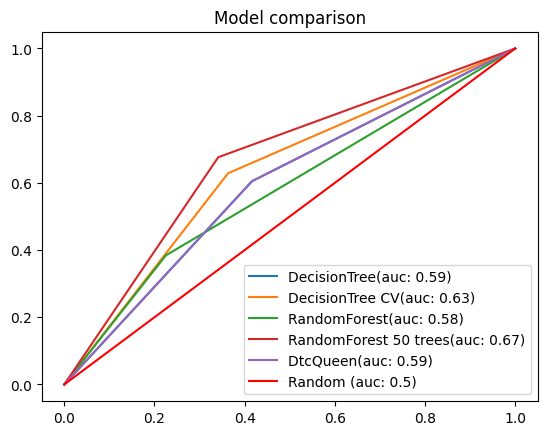

In [144]:
from sklearn.metrics import roc_curve, roc_auc_score
models = [dtc, estimator.best_estimator_, random_forest,random_forest_50_trees,dtc_kraljica]
model_names = ['DecisionTree', 'DecisionTree CV',  'RandomForest', 'RandomForest 50 trees','DtcQueen']
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    fpr,tpr, _ = roc_curve(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    lab = model_name + "(auc: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title("Model comparison")
plt.legend()
plt.show()


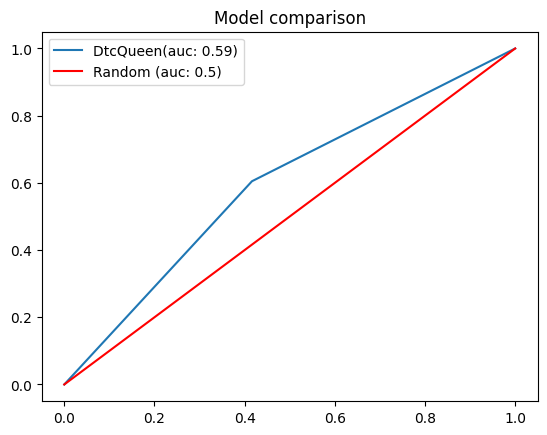

In [145]:
from sklearn.metrics import roc_curve, roc_auc_score
models = [dtc_kraljica]
model_names = ['DtcQueen']
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    fpr,tpr, _ = roc_curve(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    lab = model_name + "(auc: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title("Model comparison")
plt.legend()
plt.show()


Nismo nista dobili proveravanjem pomeranja kraljice

In [146]:
modeli=[dtc,estimator.best_estimator_,random_forest,random_forest_50_trees]

In [ ]:
from joblib import dump
dump(modeli, 'decision_trees_modeli.joblib')

['decision_trees_modeli.joblib']

In [ ]:
import os
print(os.getcwd())
#ovde su je moj joblib fajl


/content
